# 1. Setup

## 1-1. Library Setup

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2031946378980166727
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17090521103360463800
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [3]:
!nvidia-smi

Sat Dec 18 04:59:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    32W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 1-2. parameter setup

In [5]:
basemodel = 'DenseNet121'
image_size = 128
image_channels = 3
batch_size = 64
num_epochs = 100
class_num = 3
None_patience_num = 30
imagenet_patience_num = 20
S_all_labels = "S0", "S1", "S2"
T_all_labels = "T0", "T1", "T2"

#base_path = ''
base_path = 'gdrive/My Drive/Research_3_2_1/'

path_data = base_path + 'data_numpy/'
path_model_result = base_path + 'model_result/1 - Base_model_result/' + basemodel + '/'

In [6]:
S_model_name_imagenet = 'S_' + basemodel + '_imagenet'
S_model_name_None = 'S_' + basemodel + '_None'
T_model_name_imagenet = 'T_' + basemodel + '_imagenet'
T_model_name_None = 'T_' + basemodel + '_None'

print(S_model_name_None, S_model_name_imagenet, T_model_name_None, T_model_name_imagenet)

basemodel_list=[S_model_name_imagenet, S_model_name_None, T_model_name_imagenet, T_model_name_None]
basemodel_list

S_DenseNet121_None S_DenseNet121_imagenet T_DenseNet121_None T_DenseNet121_imagenet


['S_DenseNet121_imagenet',
 'S_DenseNet121_None',
 'T_DenseNet121_imagenet',
 'T_DenseNet121_None']

In [7]:
def createDirectory(name): 
    try: 
        if not os.path.exists(name): 
            os.makedirs(path_model_result + name) 
    except OSError: 
        print("Error: Failed to create the directory.")  
        
for i in basemodel_list:
    createDirectory(i)

# 2. Data Load and Image Check

## 2-1. Data Load

In [8]:
xTrain_S = np.load(path_data + 'xTrain_S.npy')
xValid_S = np.load(path_data + 'xValid_S.npy')
xTest_S = np.load(path_data + 'xTest_S.npy')

yTrain_S = np.load(path_data + 'yTrain_S.npy')
yValid_S = np.load(path_data + 'yValid_S.npy')
yTest_S = np.load(path_data + 'yTest_S.npy')

xTrain_T = np.load(path_data + 'xTrain_T.npy')
xValid_T = np.load(path_data + 'xValid_T.npy')
xTest_T = np.load(path_data + 'xTest_T.npy')

yTrain_T = np.load(path_data + 'yTrain_T.npy')
yValid_T = np.load(path_data + 'yValid_T.npy')
yTest_T = np.load(path_data + 'yTest_T.npy')

In [9]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(1440, 128, 128, 3) (1440, 1)
(480, 128, 128, 3) (480, 1)
(480, 128, 128, 3) (480, 1)

(1920, 128, 128, 3) (1920, 1)
(640, 128, 128, 3) (640, 1)
(640, 128, 128, 3) (640, 1)


In [10]:
xTrain_S = xTrain_S.astype('float32')/255
xValid_S = xValid_S.astype('float32')/255
xTest_S = xTest_S.astype('float32')/255

yTrain_S = np_utils.to_categorical(yTrain_S, class_num)
yValid_S = np_utils.to_categorical(yValid_S, class_num)
yTest_S = np_utils.to_categorical(yTest_S, class_num)

xTrain_T = xTrain_T.astype('float32')/255
xValid_T = xValid_T.astype('float32')/255
xTest_T = xTest_T.astype('float32')/255

yTrain_T = np_utils.to_categorical(yTrain_T, class_num)
yValid_T = np_utils.to_categorical(yValid_T, class_num)
yTest_T = np_utils.to_categorical(yTest_T, class_num)

In [11]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(1440, 128, 128, 3) (1440, 3)
(480, 128, 128, 3) (480, 3)
(480, 128, 128, 3) (480, 3)

(1920, 128, 128, 3) (1920, 3)
(640, 128, 128, 3) (640, 3)
(640, 128, 128, 3) (640, 3)


## 2-2. Image Check

xTrain_S image Numbers :  1440
xTrain_S image Numbers // 10 :  144
10


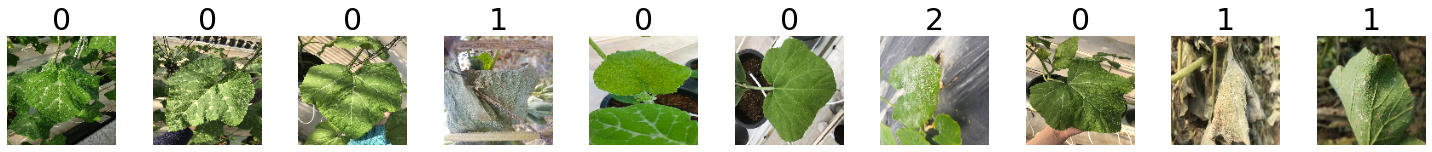

In [12]:
temp_S_a = len(xTrain_S)
print("xTrain_S image Numbers : ", temp_S_a)
temp_S_b = temp_S_a//10
print("xTrain_S image Numbers // 10 : ", temp_S_b)
temp_S_c = 0
for i in range(0, temp_S_a, temp_S_b):
    temp_S_c += 1
print(temp_S_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0, temp_S_a, temp_S_b):
    plt.subplot(1, temp_S_c, c+1)
    plt.imshow(xTrain_S[i])
    plt.title(yTrain_S[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

xTrain_S image Numbers :  1920
xTrain_S image Numbers // 10 :  192
10


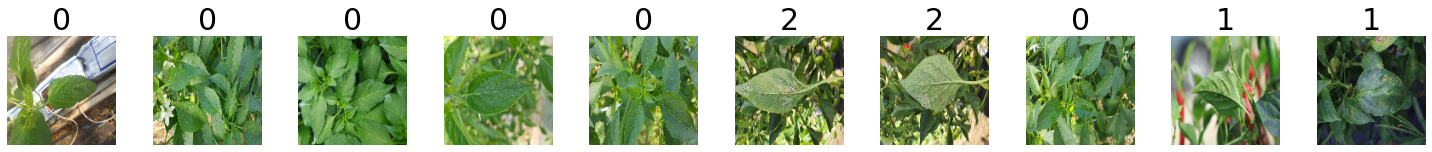

In [13]:
temp_T_a = len(xTrain_T)
print("xTrain_S image Numbers : ", temp_T_a)
temp_T_b = temp_T_a//10
print("xTrain_S image Numbers // 10 : ", temp_T_b)
temp_T_c = 0
for i in range(0, temp_T_a, temp_T_b):
    temp_T_c += 1
print(temp_T_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0,temp_T_a,temp_T_b):
    plt.subplot(1, temp_T_c, c+1)
    plt.imshow(xTrain_T[i])
    plt.title(yTrain_T[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

# 3. Network Setting and Training

## 3-1. Network Setting

In [14]:
def feature_extractor_None(inp):
    base_model=tf.keras.applications.DenseNet121 (
                include_top=False, weights=None, input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_None(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_None():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_None(inp)
    classifier_output = classifier_None(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [15]:
def feature_extractor_imagenet(inp):
    base_model=tf.keras.applications.DenseNet121 (
                include_top=False, weights='imagenet', input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_imagenet(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_imagenet():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_imagenet(inp)
    classifier_output = classifier_imagenet(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [16]:
#plot_model(model_None())
#plot_model(model_imagenet())

## 3-2. Source Domain Training - weights=None

In [17]:
S_basemodel_None=model_None()
#S_basemodel_None.summary()

In [18]:
S_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

S_basemodel_None_main =S_basemodel_None.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
23/23 [==============================] - 25s 267ms/step - loss: 0.4464 - accuracy: 0.8167 - val_loss: 1.2867 - val_accuracy: 0.2458
Epoch 2/100
23/23 [==============================] - 4s 154ms/step - loss: 0.1700 - accuracy: 0.9444 - val_loss: 4.4300 - val_accuracy: 0.2500
Epoch 3/100
23/23 [==============================] - 3s 148ms/step - loss: 0.0987 - accuracy: 0.9674 - val_loss: 3.5230 - val_accuracy: 0.2438
Epoch 4/100
23/23 [==============================] - 4s 154ms/step - loss: 0.0964 - accuracy: 0.9660 - val_loss: 2.9696 - val_accuracy: 0.2750
Epoch 5/100
23/23 [==============================] - 3s 148ms/step - loss: 0.0582 - accuracy: 0.9792 - val_loss: 6.4687 - val_accuracy: 0.2500
Epoch 6/100
23/23 [==============================] - 3s 148ms/step - loss: 0.0703 - accuracy: 0.9771 - val_loss: 5.0732 - val_accuracy: 0.2500
Epoch 7/100
23/23 [==============================] - 3s 148ms/step - loss: 0.0797 - accuracy: 0.9722 - val_loss: 12.0250 - val_accuracy: 0.25

In [19]:
S_basemodel_None_df = pd.DataFrame(S_basemodel_None_main.history)
S_basemodel_None_df.to_csv( path_model_result + S_model_name_None + '/' + S_model_name_None + '_df.csv' )
S_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,0.446433,0.816667,1.286728,0.245833
1,0.170009,0.944444,4.429957,0.250000
2,0.098686,0.967361,3.522980,0.243750
3,0.096396,0.965972,2.969600,0.275000
4,0.058181,0.979167,6.468674,0.250000
...,...,...,...,...
61,0.001706,1.000000,0.461133,0.875000
62,0.003224,0.998611,0.294277,0.916667
63,0.002893,0.998611,0.223672,0.933333
64,0.014060,0.996528,0.812730,0.856250


Minimum validation loss: 0.13933983445167542
Maximum validation accuracy: 0.96875


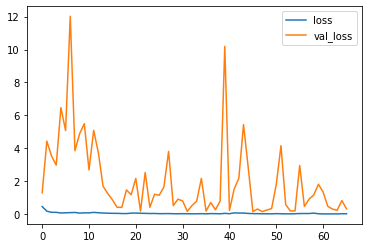

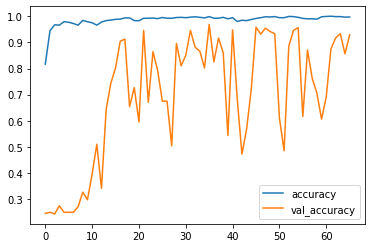

In [20]:
S_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_loss,val_loss.png')
S_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_None_df['val_accuracy'].max()))

In [21]:
print("Evaluate on test data")
S_basemodel_None_results = S_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_basemodel_None_results)

Evaluate on test data
15/15 [==============================] - 2s 26ms/step - loss: 0.0382 - accuracy: 0.9896
test loss, test acc: [0.03823649510741234, 0.9895833134651184]


In [22]:
S_basemodel_None_pred_Y = S_basemodel_None.predict(xTest_S, verbose = True)

15/15 [==============================] - 2s 24ms/step


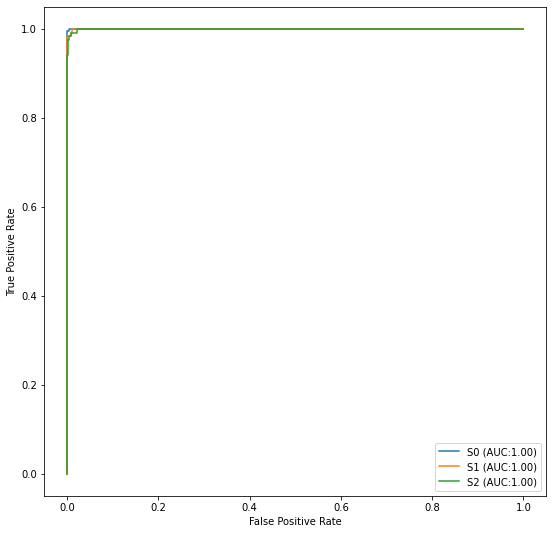

In [23]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_None + '/' + S_model_name_None +'_TESTSET_AUC.png' )

## 3-3. Source Domain Training - weights='imagenet'

In [24]:
S_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

29097984/29084464 [==============================] - 2s 0us/step


In [25]:
S_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

S_basemodel_imagenet_main =S_basemodel_imagenet.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
23/23 [==============================] - 15s 235ms/step - loss: 0.2031 - accuracy: 0.9319 - val_loss: 0.8903 - val_accuracy: 0.7104
Epoch 2/100
23/23 [==============================] - 4s 163ms/step - loss: 0.0725 - accuracy: 0.9792 - val_loss: 154.4820 - val_accuracy: 0.5000
Epoch 3/100
23/23 [==============================] - 3s 149ms/step - loss: 0.0537 - accuracy: 0.9826 - val_loss: 145.0547 - val_accuracy: 0.5000
Epoch 4/100
23/23 [==============================] - 3s 148ms/step - loss: 0.0594 - accuracy: 0.9778 - val_loss: 3.0379 - val_accuracy: 0.5896
Epoch 5/100
23/23 [==============================] - 3s 149ms/step - loss: 0.0525 - accuracy: 0.9812 - val_loss: 17.6344 - val_accuracy: 0.5000
Epoch 6/100
23/23 [==============================] - 3s 148ms/step - loss: 0.0282 - accuracy: 0.9924 - val_loss: 16.0326 - val_accuracy: 0.5583
Epoch 7/100
23/23 [==============================] - 4s 155ms/step - loss: 0.0222 - accuracy: 0.9917 - val_loss: 2.2850 - val_accuracy:

In [26]:
S_basemodel_imagenet_df = pd.DataFrame(S_basemodel_imagenet_main.history)
S_basemodel_imagenet_df.to_csv( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_df.csv' )
S_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.203140,0.931944,0.890311,0.710417
1,0.072481,0.979167,154.482040,0.500000
2,0.053683,0.982639,145.054749,0.500000
3,0.059385,0.977778,3.037945,0.589583
4,0.052524,0.981250,17.634418,0.500000
5,0.028210,0.992361,16.032600,0.558333
6,0.022203,0.991667,2.285007,0.797917
7,0.014509,0.995139,1.803985,0.785417
8,0.010437,0.996528,0.372383,0.918750
9,0.016323,0.995833,0.909159,0.852083


Minimum validation loss: 0.031914204359054565
Maximum validation accuracy: 0.9958333373069763


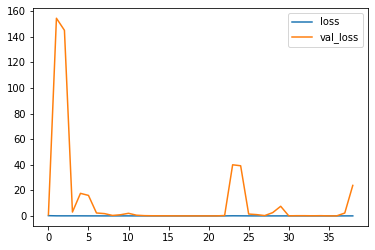

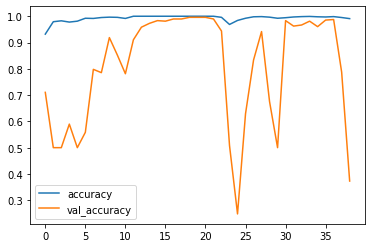

In [27]:
S_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_loss,val_loss.png')
S_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_imagenet_df['val_accuracy'].max()))

In [28]:
print("Evaluate on test data")
S_model_name_imagenet_results = S_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_model_name_imagenet_results)

Evaluate on test data
15/15 [==============================] - 2s 27ms/step - loss: 0.0298 - accuracy: 0.9875
test loss, test acc: [0.02980661392211914, 0.987500011920929]


In [29]:
S_model_name_imagenet_pred_Y = S_basemodel_imagenet.predict(xTest_S, verbose = True)

15/15 [==============================] - 2s 24ms/step


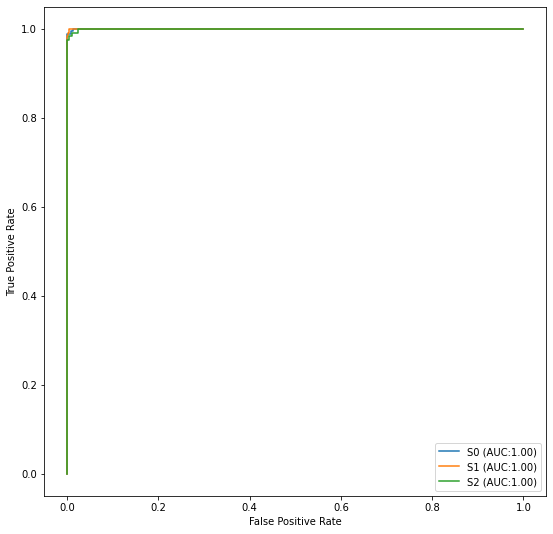

In [30]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet +'_TESTSET_AUC.png' )

## 3-4. Target Domain Training - weights=None

In [31]:
T_basemodel_None=model_None()
#S_basemodel_None.summary()

In [32]:
T_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

T_basemodel_None_main =T_basemodel_None.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
30/30 [==============================] - 16s 211ms/step - loss: 0.6392 - accuracy: 0.7443 - val_loss: 1.2401 - val_accuracy: 0.3000
Epoch 2/100
30/30 [==============================] - 5s 153ms/step - loss: 0.4086 - accuracy: 0.8479 - val_loss: 1.1206 - val_accuracy: 0.3422
Epoch 3/100
30/30 [==============================] - 5s 153ms/step - loss: 0.3517 - accuracy: 0.8714 - val_loss: 1.3672 - val_accuracy: 0.4703
Epoch 4/100
30/30 [==============================] - 4s 148ms/step - loss: 0.3318 - accuracy: 0.8828 - val_loss: 1.4962 - val_accuracy: 0.4000
Epoch 5/100
30/30 [==============================] - 5s 152ms/step - loss: 0.2705 - accuracy: 0.8953 - val_loss: 1.3168 - val_accuracy: 0.5000
Epoch 6/100
30/30 [==============================] - 4s 148ms/step - loss: 0.2198 - accuracy: 0.9240 - val_loss: 4.5285 - val_accuracy: 0.5000
Epoch 7/100
30/30 [==============================] - 4s 148ms/step - loss: 0.2058 - accuracy: 0.9229 - val_loss: 1.2593 - val_accuracy: 0.500

In [33]:
T_basemodel_None_df = pd.DataFrame(T_basemodel_None_main.history)
T_basemodel_None_df.to_csv( path_model_result + T_model_name_None + '/' + T_model_name_None + '_df.csv' )
T_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,0.639221,0.744271,1.240100,0.300000
1,0.408633,0.847917,1.120598,0.342187
2,0.351726,0.871354,1.367195,0.470313
3,0.331788,0.882812,1.496243,0.400000
4,0.270493,0.895312,1.316778,0.500000
...,...,...,...,...
95,0.000503,1.000000,0.265797,0.948438
96,0.001705,0.999479,2.219066,0.748438
97,0.004213,0.998438,0.586676,0.889063
98,0.002183,0.999479,0.435470,0.910937


Minimum validation loss: 0.19538018107414246
Maximum validation accuracy: 0.9546874761581421


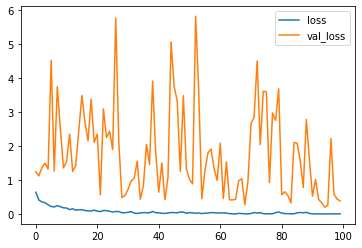

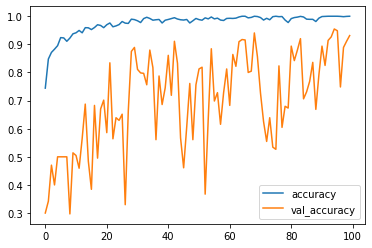

In [34]:
T_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_loss,val_loss.png')
T_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_None_df['val_accuracy'].max()))

In [35]:
print("Evaluate on test data")
T_basemodel_None_results = T_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_basemodel_None_results)

Evaluate on test data
20/20 [==============================] - 2s 26ms/step - loss: 0.3627 - accuracy: 0.9328
test loss, test acc: [0.36273622512817383, 0.932812511920929]


In [36]:
T_basemodel_None_pred_Y = T_basemodel_None.predict(xTest_T, verbose = True)

20/20 [==============================] - 2s 25ms/step


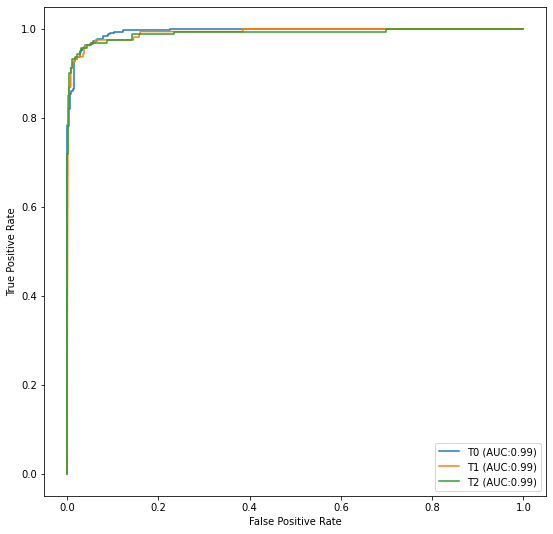

In [37]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_None + '/' + T_model_name_None + '_TESTSET_AUC.png' )

## 3-5. Target Domain Training - weights='imagenet'

In [38]:
T_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

In [39]:
T_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

T_basemodel_imagenet_main =T_basemodel_imagenet.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
30/30 [==============================] - 16s 214ms/step - loss: 0.3197 - accuracy: 0.8734 - val_loss: 9.3204 - val_accuracy: 0.5531
Epoch 2/100
30/30 [==============================] - 5s 154ms/step - loss: 0.1565 - accuracy: 0.9510 - val_loss: 9.3941 - val_accuracy: 0.5594
Epoch 3/100
30/30 [==============================] - 5s 154ms/step - loss: 0.0653 - accuracy: 0.9760 - val_loss: 3.5565 - val_accuracy: 0.6703
Epoch 4/100
30/30 [==============================] - 5s 153ms/step - loss: 0.0602 - accuracy: 0.9839 - val_loss: 2.3710 - val_accuracy: 0.7594
Epoch 5/100
30/30 [==============================] - 4s 149ms/step - loss: 0.0683 - accuracy: 0.9781 - val_loss: 2.7751 - val_accuracy: 0.7547
Epoch 6/100
30/30 [==============================] - 4s 149ms/step - loss: 0.0717 - accuracy: 0.9818 - val_loss: 8.5414 - val_accuracy: 0.6438
Epoch 7/100
30/30 [==============================] - 5s 154ms/step - loss: 0.0406 - accuracy: 0.9891 - val_loss: 0.3649 - val_accuracy: 0.906

In [40]:
T_basemodel_imagenet_df = pd.DataFrame(T_basemodel_imagenet_main.history)
T_basemodel_imagenet_df.to_csv( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_df.csv' )
T_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.319657,0.873438,9.320356,0.553125
1,0.156497,0.951042,9.394141,0.559375
2,0.065320,0.976042,3.556460,0.670313
3,0.060155,0.983854,2.370981,0.759375
4,0.068279,0.978125,2.775065,0.754687
...,...,...,...,...
68,0.043446,0.988021,2.029909,0.690625
69,0.026111,0.991667,4.386333,0.590625
70,0.012705,0.997917,0.669761,0.879687
71,0.005257,0.998958,1.852715,0.767187


Minimum validation loss: 0.05496395751833916
Maximum validation accuracy: 0.9828125238418579


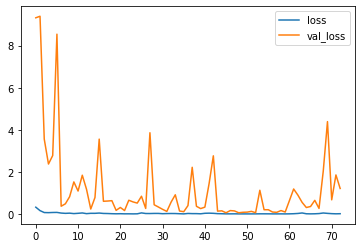

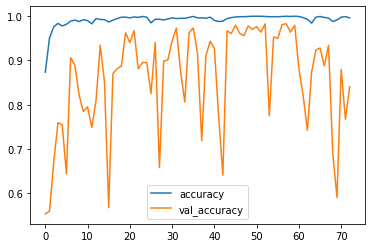

In [41]:
T_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_loss,val_loss.png')
T_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_imagenet_df['val_accuracy'].max()))

In [42]:
print("Evaluate on test data")
T_model_name_imagenet_results = T_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_model_name_imagenet_results)

Evaluate on test data
20/20 [==============================] - 2s 27ms/step - loss: 0.0368 - accuracy: 0.9937
test loss, test acc: [0.036808956414461136, 0.9937499761581421]


In [43]:
T_model_name_imagenet_pred_Y = T_basemodel_imagenet.predict(xTest_T, verbose = True)

20/20 [==============================] - 2s 25ms/step


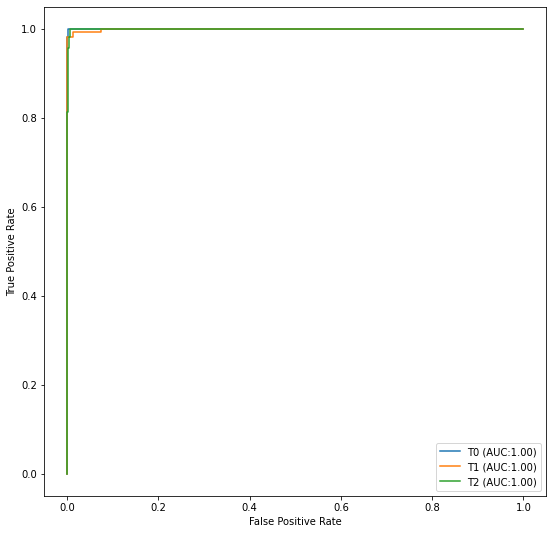

In [44]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_TESTSET_AUC.png' )

# 4. Result Report

In [45]:
print(S_model_name_None)
print("test loss, test acc:", S_basemodel_None_results)

S_DenseNet121_None
test loss, test acc: [0.03823649510741234, 0.9895833134651184]


In [46]:
print(S_model_name_imagenet)
print("test loss, test acc:", S_model_name_imagenet_results)

S_DenseNet121_imagenet
test loss, test acc: [0.02980661392211914, 0.987500011920929]


In [47]:
print(T_model_name_None)
print("test loss, test acc:", T_basemodel_None_results)

T_DenseNet121_None
test loss, test acc: [0.36273622512817383, 0.932812511920929]


In [48]:
print(T_model_name_imagenet)
print("test loss, test acc:", T_model_name_imagenet_results)

T_DenseNet121_imagenet
test loss, test acc: [0.036808956414461136, 0.9937499761581421]


# 5. Source Domain Training Model ↔ Target Domain Training Model 상호 Test Data Set 평가 

In [49]:
print( S_model_name_None + " →→→ Target Test")
S_basemodel_None_results_T = S_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_basemodel_None_results_T)

S_DenseNet121_None →→→ Target Test
20/20 [==============================] - 1s 25ms/step - loss: 6.6329 - accuracy: 0.4578
test loss, test acc: [6.6329345703125, 0.45781248807907104]


In [50]:
print( S_model_name_imagenet + " →→→ Target Test")
S_model_name_imagenet_results_T = S_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_model_name_imagenet_results_T)

S_DenseNet121_imagenet →→→ Target Test
20/20 [==============================] - 1s 27ms/step - loss: 3.1182 - accuracy: 0.4250
test loss, test acc: [3.118220806121826, 0.42500001192092896]


In [51]:
print( T_model_name_None + " →→→ Source Test")
T_basemodel_None_results_S = T_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_basemodel_None_results_S)

T_DenseNet121_None →→→ Source Test
15/15 [==============================] - 0s 27ms/step - loss: 6.1620 - accuracy: 0.5063
test loss, test acc: [6.161966323852539, 0.5062500238418579]


In [52]:
print( T_model_name_imagenet + " →→→ Source Test")
T_model_name_imagenet_results_S = T_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_model_name_imagenet_results_S)

T_DenseNet121_imagenet →→→ Source Test
15/15 [==============================] - 0s 27ms/step - loss: 4.0959 - accuracy: 0.5437
test loss, test acc: [4.095898151397705, 0.543749988079071]


# 6. Model Save 

In [53]:
S_basemodel_None.save( path_model_result + S_model_name_None + '/' + S_model_name_None + '.h5' )
S_basemodel_imagenet.save( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '.h5' )
T_basemodel_None.save( path_model_result + T_model_name_None + '/' + T_model_name_None + '.h5' )
T_basemodel_imagenet.save( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '.h5' )